In [1]:
!pip install wandb pyyaml opencv-python;

In [30]:
import os
import yaml
import glob
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import wandb
from wandb.integration.keras import WandbCallback
import matplotlib.pyplot as plt

In [3]:
wandb.login(key="017feefe0af6702cda76aab121ec71cf3a362fec")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: samutheman (rueedi-tobias-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
dataset_yaml = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/data.yaml"
images_trainset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/train"
labels_trainset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/train"
images_valset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/val"
labels_valset = "/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/val"
images_testset = False#"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/images/test"
labels_testset = False#"/exchange/dspro2/M-AI-ZE/data/adjusted/1.1/splits/SID01/labels/test"


In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
with open(dataset_yaml, "r") as f:
    config = yaml.safe_load(f)


In [7]:
# --- Parameters (tweak these to your dataset) ---
IMG_SIZE    = 256
GRID_SIZE   = 8
NUM_CLASSES = 1   #
NUM_BOXES   = 1    # number of anchors per cell
OUTPUT_SHAPE = (GRID_SIZE, GRID_SIZE, NUM_BOXES * (5 + NUM_CLASSES))

In [16]:
def build_yolo_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = tf.keras.Input(shape=input_shape)
    def conv_bn_leaky(x, filters):
        x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        return layers.LeakyReLU(alpha=0.1)(x)

    x = conv_bn_leaky(inputs, 16)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 32)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 64)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 128)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 256)
    x = layers.MaxPool2D(2)(x)
    x = conv_bn_leaky(x, 256)
    #x = layers.MaxPool2D(2)(x)
    #x = conv_bn_leaky(x, 512)
    #x = layers.MaxPool2D(2)(x)
    #x = conv_bn_leaky(x, 512)

    # prediction layer
    x = layers.Conv2D(
        NUM_BOXES * (5 + NUM_CLASSES),
        kernel_size=1,
        padding='same',
        activation='sigmoid'
    )(x)
    output = layers.Reshape((GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))(x)

    return tf.keras.Model(inputs, output)

In [17]:
# --- YOLO loss with binary class ---
def yolo_loss(y_true, y_pred):
    # reshape to (..., S, S, B, 5 + C)
    pred = tf.reshape(y_pred, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    true = tf.reshape(y_true, (-1, GRID_SIZE, GRID_SIZE, NUM_BOXES, 5 + NUM_CLASSES))
    obj_mask = true[..., 4:5]

    # localization losses
    xy_loss = tf.reduce_sum(obj_mask * tf.square(true[..., 0:2] - pred[..., 0:2]))
    wh_loss = tf.reduce_sum(obj_mask * tf.square(
        tf.sqrt(true[..., 2:4] + 1e-6) - tf.sqrt(pred[..., 2:4] + 1e-6)
    ))

    # objectness and class losses
    obj_loss = tf.reduce_sum(
        tf.keras.losses.binary_crossentropy(true[..., 4:5], pred[..., 4:5])
    )
    class_bce = tf.keras.losses.binary_crossentropy(true[..., 5:], pred[..., 5:])
    class_bce = tf.expand_dims(class_bce, axis=-1)
    class_loss = tf.reduce_sum(obj_mask * class_bce)

    return xy_loss + wh_loss + obj_loss + class_loss

In [18]:
def load_yolo_dataset(image_dir, label_dir, img_size=IMG_SIZE):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
    x_data, y_data = [], []

    # Prepare output shape dynamically if not predefined
    output_shape = (GRID_SIZE, GRID_SIZE, 5 + NUM_CLASSES)

    for img_path in image_paths:
        filename = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, f"{filename}.txt")

        # Load and preprocess image
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size))
        # Ensure float32 to save memory
        img = img.astype(np.float32) / 255.0
        x_data.append(img)

        # Create empty label grid
        label = np.zeros(output_shape, dtype=np.float32)

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                lines = f.readlines()

            for line in lines:
                class_id, x, y, w, h = map(float, line.strip().split())
                
                # Compute cell indices, clamped to valid range
                gx = min(int(x * GRID_SIZE), GRID_SIZE - 1)
                gy = min(int(y * GRID_SIZE), GRID_SIZE - 1)

                # Relative coordinates within the cell
                cell_x = x * GRID_SIZE - gx
                cell_y = y * GRID_SIZE - gy

                # Assign bounding-box attributes and objectness
                label[gy, gx, 0:5] = cell_x, cell_y, w, h, 1.0
                # One-hot class vector starting at channel 5
                label[gy, gx, 5 + int(class_id)] = 1.0

        y_data.append(label)

    return np.array(x_data, dtype=np.float32), np.array(y_data, dtype=np.float32)

In [19]:
x_train, y_train = load_yolo_dataset(images_trainset, labels_trainset)
x_val, y_val     = load_yolo_dataset(images_valset, labels_valset)
if images_testset:
    x_test, y_test = load_yolo_dataset(images_testset , labels_testset)

In [20]:
x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
x_val   = np.array(x_val,   dtype=np.float32)
y_val   = np.array(y_val,   dtype=np.float32)

In [21]:
wandb.init(project="Own CNN", name="Detector", config=config)

In [22]:
print("x_train type:", type(x_train))
print("x_train shape:", getattr(x_train, 'shape', 'No shape'))
print("y_train shape:", getattr(y_train, 'shape', 'No shape'))
#print("First element:", x_train[0])
#print("First element ", x_train[0])

x_train type: <class 'numpy.ndarray'>
x_train shape: (10858, 256, 256, 3)
y_train shape: (10858, 8, 8, 6)


In [23]:
model = build_yolo_model()
model.compile(optimizer='adam', loss=yolo_loss)
model.summary()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 256, 256, 16)   │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       589,824 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 986,486 (3.76 MB)

 Trainable params: 984,982 (3.76 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [24]:
batch_size = 8  # try smaller if still OOM

train_ds = (
    tf.data.Dataset
      .from_tensor_slices((x_train, y_train))
      .shuffle(1024)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset
      .from_tensor_slices((x_val, y_val))
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[WandbCallback(save_graph=False, save_model=False)]
)

2025-05-09 05:51:11.819169: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
2025-05-09 05:51:16.809382: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/10


2025-05-09 05:51:20.796872: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8539078656 exceeds 10% of free system memory.
I0000 00:00:1746769886.803716   13078 service.cc:146] XLA service 0x7f1f040133d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746769886.803765   13078 service.cc:154]   StreamExecutor device (0): NVIDIA A16, Compute Capability 8.6
2025-05-09 05:51:26.916974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-09 05:51:27.219973: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-05-09 05:51:34.009728: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel 

  10/1358 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 317.3649

I0000 00:00:1746769895.275000   13078 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - loss: 145.2148 - val_loss: 142.0013
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 106.2898 - val_loss: 170.7982
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 98.3280 - val_loss: 137.7573
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 93.1854 - val_loss: 115.1351
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 88.0700 - val_loss: 139.2267
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 84.0596 - val_loss: 117.6208
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 79.8472 - val_loss: 118.2887
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 75.2494 - val_loss: 119.8823
Epoch 9/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 69.9589 - val_loss: 126.2985
Epoch 10/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 63.7288 - val_loss: 132.3341


In [25]:
def draw_boxes(image, label_grid, pred_grid, conf_thresh=0.5):
    # Remove the box axis: (4,4,1,6) → (4,4,6)
    pred_grid = np.squeeze(pred_grid, axis=2)

    img = (image * 255).astype(np.uint8).copy()
    h, w, _ = img.shape
    cell_h, cell_w = h // GRID_SIZE, w // GRID_SIZE

    # True labels (green)
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            if label_grid[gy, gx, 4] > 0.5:
                x, y, bw, bh = label_grid[gy, gx, :4]
                cx = int((gx + x) * cell_w)
                cy = int((gy + y) * cell_h)
                bw = int(bw * w)
                bh = int(bh * h)
                cv2.rectangle(
                    img,
                    (cx - bw//2, cy - bh//2),
                    (cx + bw//2, cy + bh//2),
                    (0, 255, 0), 2
                )

    # Predicted boxes (blue)
    for gy in range(GRID_SIZE):
        for gx in range(GRID_SIZE):
            if pred_grid[gy, gx, 4] > conf_thresh:
                x, y, bw, bh = pred_grid[gy, gx, :4]
                cx = int((gx + x) * cell_w)
                cy = int((gy + y) * cell_h)
                bw = int(bw * w)
                bh = int(bh * h)
                cv2.rectangle(
                    img,
                    (cx - bw//2, cy - bh//2),
                    (cx + bw//2, cy + bh//2),
                    (255, 0, 0), 2
                )

    return img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


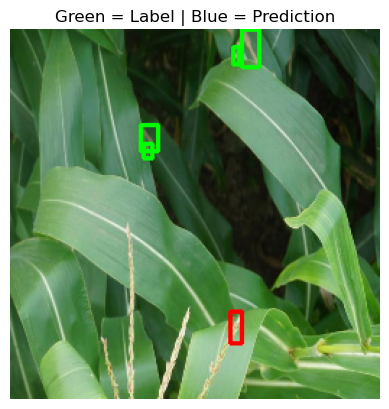

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


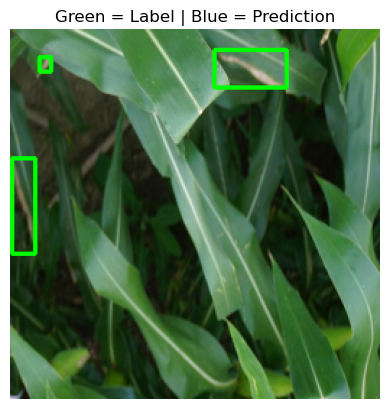

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


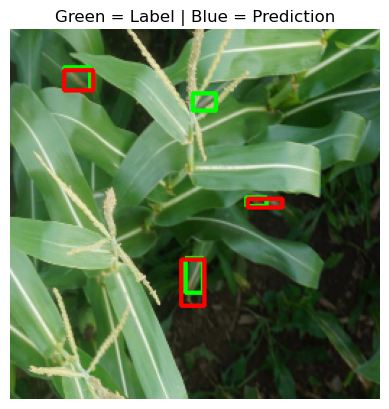

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


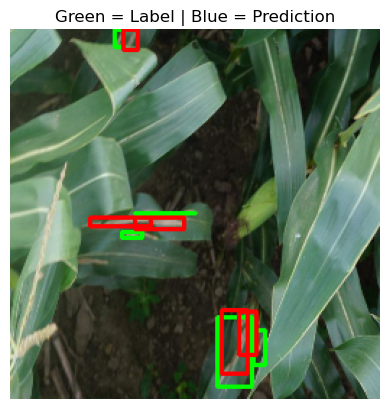

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


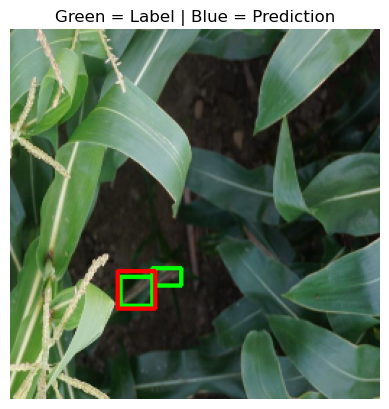

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


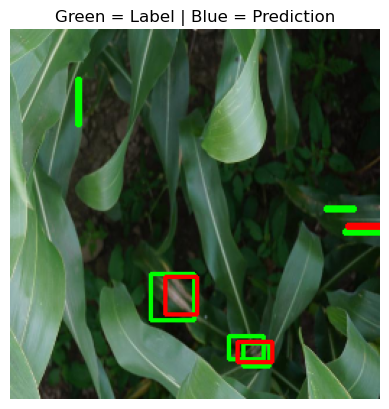

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


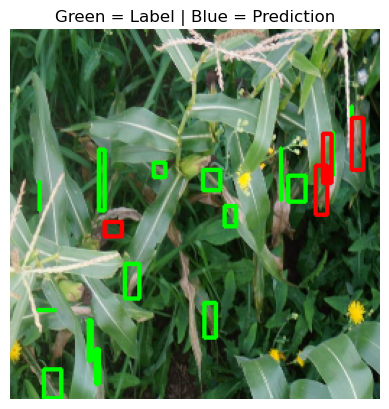

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


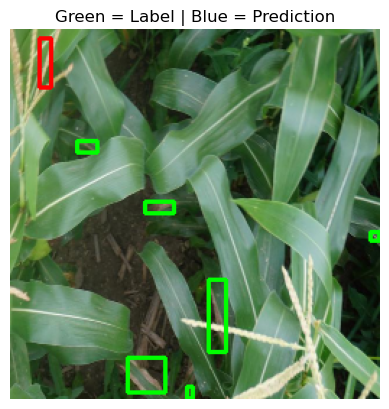

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


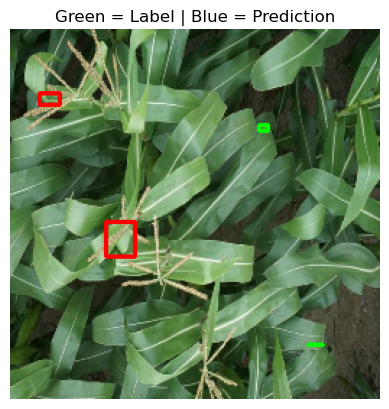

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


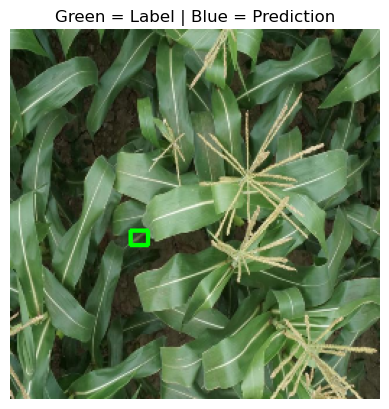

In [32]:
for i in range(10):
    image = x_val[i+30]
    label = y_val[i+30]          # shape (4,4,6)
    pred  = model.predict(image[np.newaxis])[0]  # shape (4,4,1,6)

    img = draw_boxes(image, label, pred)
    plt.imshow(img); plt.axis('off')
    plt.title("Green = Label | Blue = Prediction")
    plt.show()